---
title: "Time Series as Inputs to a Model"
format:
  html:
    code-fold: true
jupyter: python3
author: "kakamana"
date: "2023-01-24"
categories: [python, datacamp, machine learning, time series]
image: "timeSeriesInput.png"

---

# Time Series as Inputs to a Model

 To include time series in your machine learning pipeline, you use them as features in your model. We will briefly covers the common features that are extracted from time series for machine learning.

This **Time Series as Inputs to a Model** is part of [Datacamp course: Machine Learning for Time Series Data in Python](https://app.datacamp.com/learn/courses/machine-learning-for-time-series-data-in-python)

This is my learning experience of data science through DataCamp

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa as lr

plt.rcParams['figure.figsize'] = (10, 5)
plt.style.use('fivethirtyeight')

## Classifying a time series


### Many repetitions of sounds
In this exercise, you'll start with perhaps the simplest classification technique: averaging across dimensions of a dataset and visually inspecting the result.

You'll use the heartbeat data described in the last chapter. Some recordings are normal heartbeat activity, while others are abnormal activity. Let's see if you can spot the difference.

Two DataFrames, ```normal``` and ```abnormal```, each with the shape of ```(n_times_points, n_audio_files)``` containing the audio for several heartbeats are available in your workspace.

In [2]:
def show_plot_and_make_titles():
    axs[0, 0].set(title="Normal Heartbeats")
    axs[0, 1].set(title="Abnormal Heartbeats")
    plt.tight_layout()

In [3]:
normal = pd.read_csv('dataset/normal_sound.csv', index_col=0)
abnormal = pd.read_csv('dataset/abnormal_sound.csv', index_col=0)
sfreq = 2205


As you can see there is a lot of variability in the raw data, let's see if you can average out some of that noise to notice a difference.


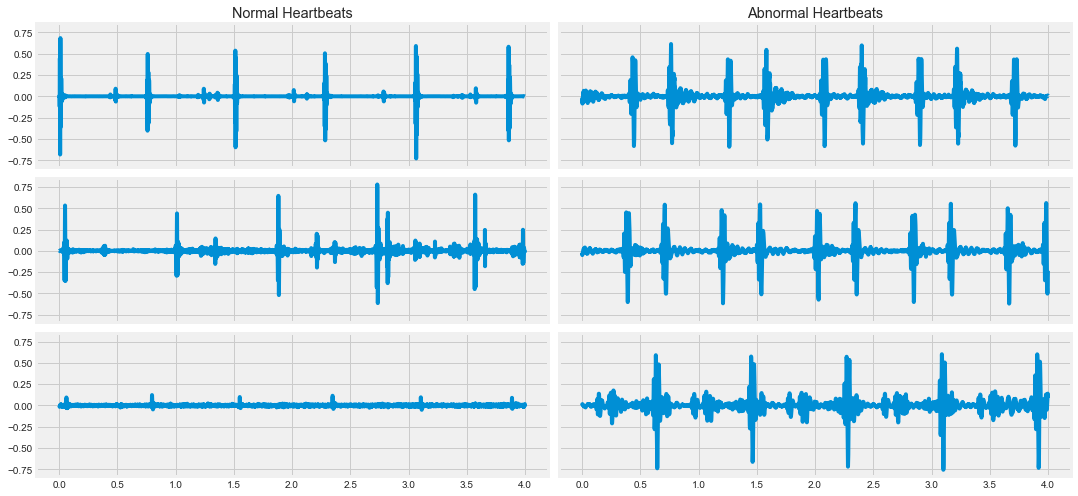

In [5]:
fig, axs = plt.subplots(3, 2, figsize=(15, 7), sharex=True, sharey=True)

# Calculate the time array
time = np.arange(len(normal)) / sfreq

# Stack the normal/abnormal audio so you can loop and plot
stacked_audio = np.hstack([normal, abnormal]).T

# Loop through each audio file / ax object and plot
# .T.ravel() transposes the array, then unravels it into a 1-D vector for looping
for iaudio, ax in zip(stacked_audio, axs.T.ravel()):
    ax.plot(time, iaudio)
show_plot_and_make_titles()
print("\nAs you can see there is a lot of variability in the raw data, let's see if you can average out some of that noise to notice a difference.")

### Invariance in time
While you should always start by visualizing your raw data, this is often uninformative when it comes to discriminating between two classes of data points. Data is usually noisy or exhibits complex patterns that aren't discoverable by the naked eye.

Another common technique to find simple differences between two sets of data is to average across multiple instances of the same class. This may remove noise and reveal underlying patterns (or, it may not).

In this exercise, you'll average across many instances of each class of heartbeat sound.

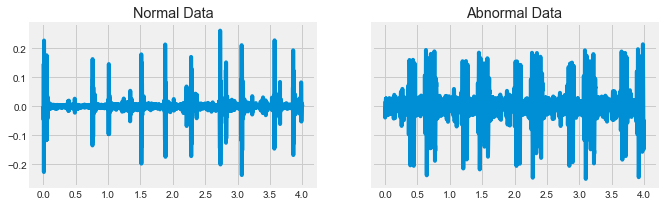

In [6]:
# Average across the audio files of each DataFrame
mean_normal = np.mean(normal, axis=1)
mean_abnormal = np.mean(abnormal, axis=1)

# Plot each average over time
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
ax1.plot(time, mean_normal);
ax1.set(title='Normal Data');
ax2.plot(time, mean_abnormal);
ax2.set(title='Abnormal Data');

### Build a classification model
While eye-balling differences is a useful way to gain an intuition for the data, let's see if you can operationalize things with a model. In this exercise, you will use each repetition as a datapoint, and each moment in time as a feature to fit a classifier that attempts to predict abnormal vs. normal heartbeats using only the raw data.

In [7]:
normal = pd.read_csv('dataset/heart_normal.csv', index_col=0)
abnormal = pd.read_csv('dataset/heart_abnormal.csv', index_col=0)

In [8]:
normal_train_idx = np.random.choice(normal.shape[1], size=22, replace=False).tolist()
normal_test_idx = list(set(np.arange(normal.shape[1]).tolist()) - set(normal_train_idx))

abnormal_train_idx = np.random.choice(abnormal.shape[1], size=20, replace=False).tolist()
abnormal_test_idx = list(set(np.arange(abnormal.shape[1]).tolist()) - set(abnormal_train_idx))

X_train = pd.concat([normal.iloc[:, normal_train_idx],
                     abnormal.iloc[:, abnormal_train_idx]], axis=1).to_numpy().T
X_test = pd.concat([normal.iloc[:, normal_test_idx],
                    abnormal.iloc[:, abnormal_test_idx]], axis=1).to_numpy().T

y_train = np.array(['normal'] * len(normal_train_idx) + ['abnormal'] * len(abnormal_train_idx))
y_test = np.array(['normal'] * len(normal_test_idx) + ['abnormal'] * len(abnormal_test_idx))

In [10]:
from sklearn.svm import LinearSVC

# Initialize and fit the model
model = LinearSVC()
model.fit(X_train, y_train)

# Generate predictions and score them manually
predictions = model.predict(X_test)
print(sum(predictions == y_test.squeeze()) / len(y_test))
print("\nNote that your predictions didn't do so well. That's because the features you're using as inputs to the model (raw data) aren't very good at differentiating classes. Next, you'll explore how to calculate some more complex features that may improve the results.")

0.5555555555555556

Note that your predictions didn't do so well. That's because the features you're using as inputs to the model (raw data) aren't very good at differentiating classes. Next, you'll explore how to calculate some more complex features that may improve the results.


### Improving features for classification
- The auditory envelope
    - Smooth the data to calculate the auditory envelope
    - Releated to the total amount of audio energy present at each moment of time
- Smoothing over time
    - Instead of averaging over all time, we can do a local average
    - This is called smoothing your timeseries
    - It removes short-term noise, while retaining the general pattern
- Auditory features: The Tempogram
    - We can summarize more complex temporal information with timeseries-specific functions
    - ```librosa``` is a great library for auditory and timeseries feature engineering
    - We can calculate summary statistics of tempo in the same way that we can for the envelope


### Calculating the envelope of sound
One of the ways you can improve the features available to your model is to remove some of the noise present in the data. In audio data, a common way to do this is to smooth the data and then rectify it so that the total amount of sound energy over time is more distinguishable. You'll do this in the current exercise.

In [13]:
audio, sfreq = lr.load('dataset/files/murmur__201108222238.wav')
time = np.arange(0, len(audio)) / sfreq

audio = pd.DataFrame(audio)

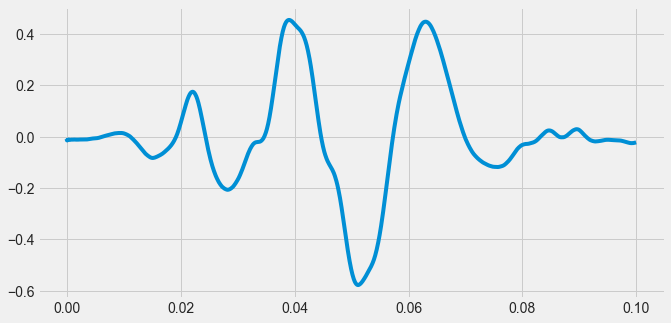

In [14]:
plt.plot(time[:2205], audio[:2205]);

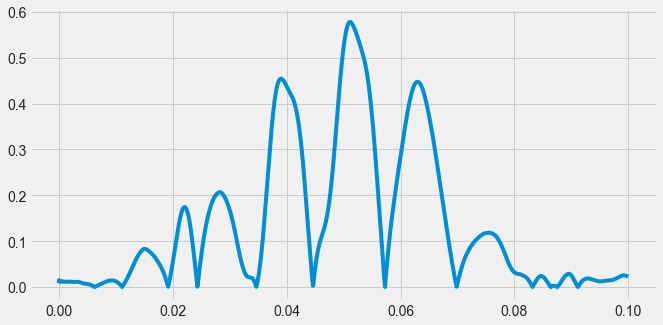

In [15]:
# Rectify the audio signal
audio_rectified = audio.apply(np.abs)

# Plot the result
plt.plot(time[:2205], audio_rectified[:2205]);


By calculating the envelope of each sound and smoothing it, you've eliminated much of the noise and have a cleaner signal to tell you when a heartbeat is happening.


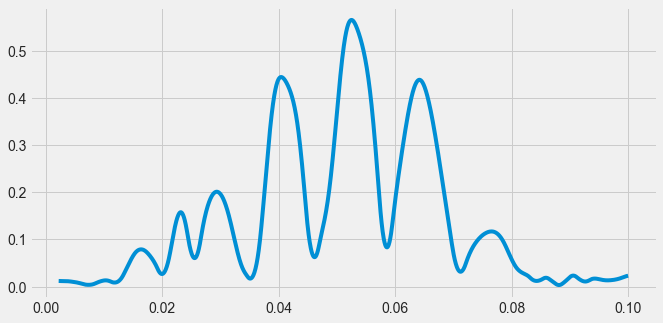

In [17]:
# Smooth by applying a rolling mean
audio_rectified_smooth = audio_rectified.rolling(50).mean()

# Plot the result
plt.plot(time[:2205], audio_rectified_smooth[:2205])
print("\nBy calculating the envelope of each sound and smoothing it, you've eliminated much of the noise and have a cleaner signal to tell you when a heartbeat is happening.")

### Calculating features from the envelope
Now that you've removed some of the noisier fluctuations in the audio, let's see if this improves your ability to classify.

In [18]:
# Calculate stats
means = np.mean(audio_rectified_smooth[:2205], axis=0)
stds = np.std(audio_rectified_smooth[:2205], axis=0)
maxs = np.max(audio_rectified_smooth[:2205], axis=0)

labels=np.array(['murmur', 'murmur', 'murmur', 'normal', 'normal', 'murmur',
       'normal', 'normal', 'murmur', 'murmur', 'normal', 'murmur',
       'normal', 'murmur', 'murmur', 'normal', 'normal', 'normal',
       'normal', 'murmur', 'normal', 'normal', 'murmur', 'murmur',
       'normal', 'normal', 'normal', 'normal', 'murmur', 'murmur',
       'murmur', 'normal', 'normal', 'normal', 'normal', 'murmur',
       'murmur', 'murmur', 'normal', 'normal', 'normal', 'murmur',
       'murmur', 'normal', 'murmur', 'murmur', 'murmur', 'murmur',
       'normal', 'normal', 'murmur', 'normal', 'normal', 'murmur',
       'murmur', 'normal', 'murmur', 'murmur', 'murmur', 'murmur'])
# Create the X and y array
X = np.column_stack([means, stds, maxs])
y = labels.reshape([-1, 1])

# Fit the model and score on testing data
from sklearn.model_selection import cross_val_score
percent_score = cross_val_score(model, X, y, cv=5)
print(np.mean(percent_score))

ValueError: Found input variables with inconsistent numbers of samples: [1, 60]

```python
# Calculate stats
means = np.mean(audio_rectified_smooth[:2205], axis=0)
stds = np.std(audio_rectified_smooth[:2205], axis=0)
maxs = np.max(audio_rectified_smooth[:2205], axis=0)

# Create the X and y array
X = np.column_stack([means, stds, maxs])
y = labels.reshape([-1, 1])

# Fit the model and score on testing data
from sklearn.model_selection import cross_val_score
percent_score = cross_val_score(model, X, y, cv=5)
print(np.mean(percent_score))
```

### Derivative features: The tempogram
One benefit of cleaning up your data is that it lets you compute more sophisticated features. For example, the envelope calculation you performed is a common technique in computing tempo and rhythm features. In this exercise, you'll use ```librosa``` to compute some tempo and rhythm features for heartbeat data, and fit a model once more.

Note that ```librosa``` functions tend to only operate on numpy arrays instead of DataFrames, so we'll access our Pandas data as a Numpy array with the ```.values``` attribute.

In [19]:
audio = pd.read_csv('dataset/heart_normal.csv',index_col=0)

In [20]:
# Calculate the tempo of the sounds
tempos = []
for col, i_audio in audio.items():
    tempos.append(lr.beat.tempo(i_audio.values, sr=sfreq, hop_length=2**6, aggregate=None))

# Convert the list to an array so you can manipulate it more easily
tempos = np.array(tempos)

# Calculate statistics of each tempo
tempos_mean = tempos.mean(axis=-1)
tempos_std = tempos.std(axis=-1)
tempos_max = tempos.max(axis=-1)

C:\Users\dghr201\AppData\Local\Temp\ipykernel_27096\3334237929.py:4: FutureWarning: Pass y=[-0.00099522 -0.00338075 -0.00094784 ... -0.00023299 -0.00010334
 -0.0003675 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  tempos.append(lr.beat.tempo(i_audio.values, sr=sfreq, hop_length=2**6, aggregate=None))
C:\Users\dghr201\AppData\Local\Temp\ipykernel_27096\3334237929.py:4: FutureWarning: Pass y=[ 2.80759443e-04  3.80784913e-04  6.25667381e-05 ... -5.90919633e-04
 -1.31961866e-03  6.51859853e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  tempos.append(lr.beat.tempo(i_audio.values, sr=sfreq, hop_length=2**6, aggregate=None))
C:\Users\dghr201\AppData\Local\Temp\ipykernel_27096\3334237929.py:4: FutureWarning: Pass y=[0.00295301 0.00303359 0.00029151 ... 0.01680872 0.00876233 0.00444242] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  

```python
# Create the X and y arrays
X = np.column_stack([means, stds, maxs, tempos_mean, tempos_std, tempos_max])
y = labels.reshape([-1, 1])

# Fit the model and score on testing data
percent_score = cross_val_score(model, X, y, cv=5)
print(np.mean(percent_score))
```

## The spectrogram
- Fourier transforms
    - Timeseries data can be described as a combination of quickly-changing things and slowly-changing things
    - At each moment in time, we can describe the relative presence of fast- and slow-moving components
    - The simplest way to do this is called a Fourier Transform
    - This converts a single time series into an array that describe the timeseries as a combination of oscillations
- Spectrograms: combinations of windows Fourier transforms
    - A spectrogram is a collection of windowsed Fourier transforms over time
    - Similar to how a rolling mean was calculated:
        - Choose a windows size and shape
        - At a timepoint, calculate the FFT for that window
        - Slide the window over by one
        - Aggregate the results
    - Called a Short-Time Fourier Transform (STFT)
- Spectral feature engineering
    - Each timeseries has a different spectral pattern
    - We can calculate these spectral patterns by analyzing the spectrogram.
    - For example, spectral bandwidth and spectran centroids describe where most of the energy is at each moment in time.

### Spectrograms of heartbeat audio
Spectral engineering is one of the most common techniques in machine learning for time series data. The first step in this process is to calculate a spectrogram of sound. This describes what spectral content (e.g., low and high pitches) are present in the sound over time. In this exercise, you'll calculate a spectrogram of a heartbeat audio file.

In [21]:
audio, sfreq = lr.load('dataset/files/murmur__201108222246.wav')

In [24]:
from librosa.core import stft, amplitude_to_db

# Prepare the STFT
HOP_LENGTH = 2**4
# spec = stft(audio, hop_length=HOP_LENGTH, n_fft=2**7)

# For the test
spec = pd.read_csv('dataset/spec.csv', index_col=0)
spec = spec.applymap(complex)
time = np.array(normal.index)
audio = pd.read_csv('dataset/audio.csv', index_col=0).to_numpy().squeeze()
sfreq = 2205

C:\Users\dghr201\AppData\Local\Programs\Python\Python39\lib\site-packages\librosa\util\decorators.py:88: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  return f(*args, **kwargs)


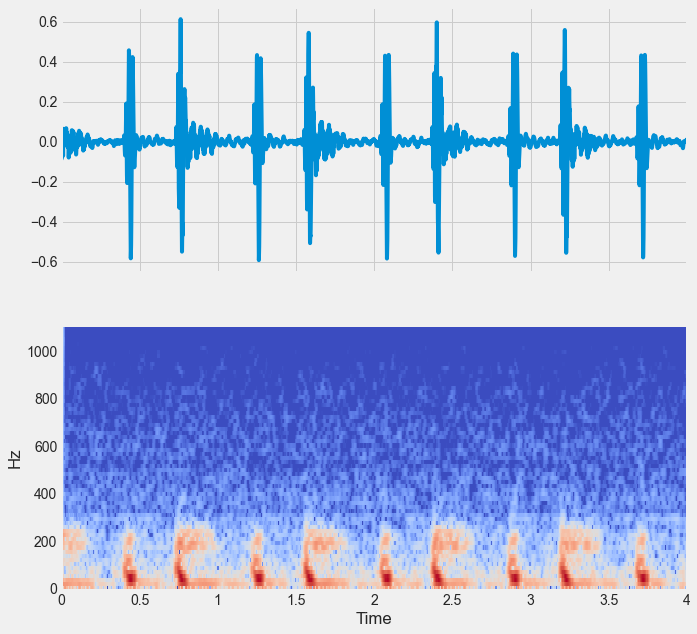

In [25]:
from librosa.display import specshow

# Convert into decibels
spec_db = amplitude_to_db(spec)

# Compare the raw audio to the spectrogram of the audio
fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
axs[0].plot(time,audio)
specshow(spec_db, sr=sfreq, x_axis='time', y_axis='hz', hop_length=HOP_LENGTH);

### Engineering spectral features
As you can probably tell, there is a lot more information in a spectrogram compared to a raw audio file. By computing the spectral features, you have a much better idea of what's going on. As such, there are all kinds of spectral features that you can compute using the spectrogram as a base. In this exercise, you'll look at a few of these features.

In [26]:
spec = np.array(np.abs(spec))

In [27]:
# Calculate the spectral centroid and bandwidth for the spectrogram
bandwidths = lr.feature.spectral_bandwidth(S=spec)[0]
centroids = lr.feature.spectral_centroid(S=spec)[0]

In [28]:
#hide
times_spec = np.array([ 0.        ,  0.00725624,  0.01451247,  0.02176871,  0.02902494,
        0.03628118,  0.04353741,  0.05079365,  0.05804989,  0.06530612,
        0.07256236,  0.07981859,  0.08707483,  0.09433107,  0.1015873 ,
        0.10884354,  0.11609977,  0.12335601,  0.13061224,  0.13786848,
        0.14512472,  0.15238095,  0.15963719,  0.16689342,  0.17414966,
        0.1814059 ,  0.18866213,  0.19591837,  0.2031746 ,  0.21043084,
        0.21768707,  0.22494331,  0.23219955,  0.23945578,  0.24671202,
        0.25396825,  0.26122449,  0.26848073,  0.27573696,  0.2829932 ,
        0.29024943,  0.29750567,  0.3047619 ,  0.31201814,  0.31927438,
        0.32653061,  0.33378685,  0.34104308,  0.34829932,  0.35555556,
        0.36281179,  0.37006803,  0.37732426,  0.3845805 ,  0.39183673,
        0.39909297,  0.40634921,  0.41360544,  0.42086168,  0.42811791,
        0.43537415,  0.44263039,  0.44988662,  0.45714286,  0.46439909,
        0.47165533,  0.47891156,  0.4861678 ,  0.49342404,  0.50068027,
        0.50793651,  0.51519274,  0.52244898,  0.52970522,  0.53696145,
        0.54421769,  0.55147392,  0.55873016,  0.56598639,  0.57324263,
        0.58049887,  0.5877551 ,  0.59501134,  0.60226757,  0.60952381,
        0.61678005,  0.62403628,  0.63129252,  0.63854875,  0.64580499,
        0.65306122,  0.66031746,  0.6675737 ,  0.67482993,  0.68208617,
        0.6893424 ,  0.69659864,  0.70385488,  0.71111111,  0.71836735,
        0.72562358,  0.73287982,  0.74013605,  0.74739229,  0.75464853,
        0.76190476,  0.769161  ,  0.77641723,  0.78367347,  0.79092971,
        0.79818594,  0.80544218,  0.81269841,  0.81995465,  0.82721088,
        0.83446712,  0.84172336,  0.84897959,  0.85623583,  0.86349206,
        0.8707483 ,  0.87800454,  0.88526077,  0.89251701,  0.89977324,
        0.90702948,  0.91428571,  0.92154195,  0.92879819,  0.93605442,
        0.94331066,  0.95056689,  0.95782313,  0.96507937,  0.9723356 ,
        0.97959184,  0.98684807,  0.99410431,  1.00136054,  1.00861678,
        1.01587302,  1.02312925,  1.03038549,  1.03764172,  1.04489796,
        1.0521542 ,  1.05941043,  1.06666667,  1.0739229 ,  1.08117914,
        1.08843537,  1.09569161,  1.10294785,  1.11020408,  1.11746032,
        1.12471655,  1.13197279,  1.13922902,  1.14648526,  1.1537415 ,
        1.16099773,  1.16825397,  1.1755102 ,  1.18276644,  1.19002268,
        1.19727891,  1.20453515,  1.21179138,  1.21904762,  1.22630385,
        1.23356009,  1.24081633,  1.24807256,  1.2553288 ,  1.26258503,
        1.26984127,  1.27709751,  1.28435374,  1.29160998,  1.29886621,
        1.30612245,  1.31337868,  1.32063492,  1.32789116,  1.33514739,
        1.34240363,  1.34965986,  1.3569161 ,  1.36417234,  1.37142857,
        1.37868481,  1.38594104,  1.39319728,  1.40045351,  1.40770975,
        1.41496599,  1.42222222,  1.42947846,  1.43673469,  1.44399093,
        1.45124717,  1.4585034 ,  1.46575964,  1.47301587,  1.48027211,
        1.48752834,  1.49478458,  1.50204082,  1.50929705,  1.51655329,
        1.52380952,  1.53106576,  1.538322  ,  1.54557823,  1.55283447,
        1.5600907 ,  1.56734694,  1.57460317,  1.58185941,  1.58911565,
        1.59637188,  1.60362812,  1.61088435,  1.61814059,  1.62539683,
        1.63265306,  1.6399093 ,  1.64716553,  1.65442177,  1.661678  ,
        1.66893424,  1.67619048,  1.68344671,  1.69070295,  1.69795918,
        1.70521542,  1.71247166,  1.71972789,  1.72698413,  1.73424036,
        1.7414966 ,  1.74875283,  1.75600907,  1.76326531,  1.77052154,
        1.77777778,  1.78503401,  1.79229025,  1.79954649,  1.80680272,
        1.81405896,  1.82131519,  1.82857143,  1.83582766,  1.8430839 ,
        1.85034014,  1.85759637,  1.86485261,  1.87210884,  1.87936508,
        1.88662132,  1.89387755,  1.90113379,  1.90839002,  1.91564626,
        1.92290249,  1.93015873,  1.93741497,  1.9446712 ,  1.95192744,
        1.95918367,  1.96643991,  1.97369615,  1.98095238,  1.98820862,
        1.99546485,  2.00272109,  2.00997732,  2.01723356,  2.0244898 ,
        2.03174603,  2.03900227,  2.0462585 ,  2.05351474,  2.06077098,
        2.06802721,  2.07528345,  2.08253968,  2.08979592,  2.09705215,
        2.10430839,  2.11156463,  2.11882086,  2.1260771 ,  2.13333333,
        2.14058957,  2.1478458 ,  2.15510204,  2.16235828,  2.16961451,
        2.17687075,  2.18412698,  2.19138322,  2.19863946,  2.20589569,
        2.21315193,  2.22040816,  2.2276644 ,  2.23492063,  2.24217687,
        2.24943311,  2.25668934,  2.26394558,  2.27120181,  2.27845805,
        2.28571429,  2.29297052,  2.30022676,  2.30748299,  2.31473923,
        2.32199546,  2.3292517 ,  2.33650794,  2.34376417,  2.35102041,
        2.35827664,  2.36553288,  2.37278912,  2.38004535,  2.38730159,
        2.39455782,  2.40181406,  2.40907029,  2.41632653,  2.42358277,
        2.430839  ,  2.43809524,  2.44535147,  2.45260771,  2.45986395,
        2.46712018,  2.47437642,  2.48163265,  2.48888889,  2.49614512,
        2.50340136,  2.5106576 ,  2.51791383,  2.52517007,  2.5324263 ,
        2.53968254,  2.54693878,  2.55419501,  2.56145125,  2.56870748,
        2.57596372,  2.58321995,  2.59047619,  2.59773243,  2.60498866,
        2.6122449 ,  2.61950113,  2.62675737,  2.63401361,  2.64126984,
        2.64852608,  2.65578231,  2.66303855,  2.67029478,  2.67755102,
        2.68480726,  2.69206349,  2.69931973,  2.70657596,  2.7138322 ,
        2.72108844,  2.72834467,  2.73560091,  2.74285714,  2.75011338,
        2.75736961,  2.76462585,  2.77188209,  2.77913832,  2.78639456,
        2.79365079,  2.80090703,  2.80816327,  2.8154195 ,  2.82267574,
        2.82993197,  2.83718821,  2.84444444,  2.85170068,  2.85895692,
        2.86621315,  2.87346939,  2.88072562,  2.88798186,  2.8952381 ,
        2.90249433,  2.90975057,  2.9170068 ,  2.92426304,  2.93151927,
        2.93877551,  2.94603175,  2.95328798,  2.96054422,  2.96780045,
        2.97505669,  2.98231293,  2.98956916,  2.9968254 ,  3.00408163,
        3.01133787,  3.0185941 ,  3.02585034,  3.03310658,  3.04036281,
        3.04761905,  3.05487528,  3.06213152,  3.06938776,  3.07664399,
        3.08390023,  3.09115646,  3.0984127 ,  3.10566893,  3.11292517,
        3.12018141,  3.12743764,  3.13469388,  3.14195011,  3.14920635,
        3.15646259,  3.16371882,  3.17097506,  3.17823129,  3.18548753,
        3.19274376,  3.2       ,  3.20725624,  3.21451247,  3.22176871,
        3.22902494,  3.23628118,  3.24353741,  3.25079365,  3.25804989,
        3.26530612,  3.27256236,  3.27981859,  3.28707483,  3.29433107,
        3.3015873 ,  3.30884354,  3.31609977,  3.32335601,  3.33061224,
        3.33786848,  3.34512472,  3.35238095,  3.35963719,  3.36689342,
        3.37414966,  3.3814059 ,  3.38866213,  3.39591837,  3.4031746 ,
        3.41043084,  3.41768707,  3.42494331,  3.43219955,  3.43945578,
        3.44671202,  3.45396825,  3.46122449,  3.46848073,  3.47573696,
        3.4829932 ,  3.49024943,  3.49750567,  3.5047619 ,  3.51201814,
        3.51927438,  3.52653061,  3.53378685,  3.54104308,  3.54829932,
        3.55555556,  3.56281179,  3.57006803,  3.57732426,  3.5845805 ,
        3.59183673,  3.59909297,  3.60634921,  3.61360544,  3.62086168,
        3.62811791,  3.63537415,  3.64263039,  3.64988662,  3.65714286,
        3.66439909,  3.67165533,  3.67891156,  3.6861678 ,  3.69342404,
        3.70068027,  3.70793651,  3.71519274,  3.72244898,  3.72970522,
        3.73696145,  3.74421769,  3.75147392,  3.75873016,  3.76598639,
        3.77324263,  3.78049887,  3.7877551 ,  3.79501134,  3.80226757,
        3.80952381,  3.81678005,  3.82403628,  3.83129252,  3.83854875,
        3.84580499,  3.85306122,  3.86031746,  3.8675737 ,  3.87482993,
        3.88208617,  3.8893424 ,  3.89659864,  3.90385488,  3.91111111,
        3.91836735,  3.92562358,  3.93287982,  3.94013605,  3.94739229,
        3.95464853,  3.96190476,  3.969161  ,  3.97641723,  3.98367347,
        3.99092971,  3.99818594])

AttributeError: 'QuadMesh' object has no attribute 'plot'

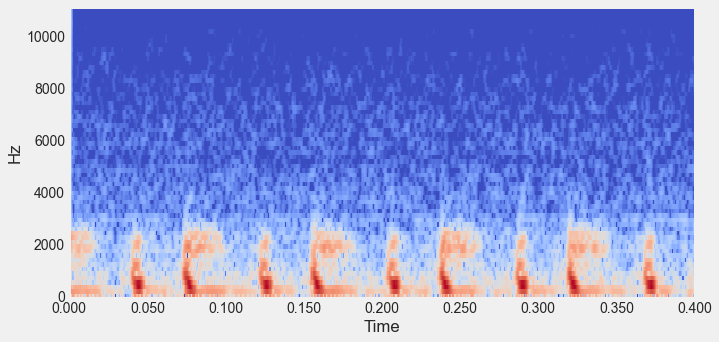

In [29]:
# Convert spectrogram to decibels for visualization
spec_db = amplitude_to_db(spec)

# Display these features on top of the spectrogram
fig, ax = plt.subplots(figsize=(10, 5))
ax = specshow(spec_db, x_axis='time', y_axis='hz', hop_length=HOP_LENGTH);
ax.plot(times_spec, centroids);
ax.fill_between(times_spec, centroids - bandwidths / 2, centroids + bandwidths / 2, alpha=.5);
ax.set(ylim=[None, 6000]);